## Loop starting from noised version of input (AKA image2image)

Let's see what happens when we use our image as a starting point, adding some noise and then doing the final few denoising steps in the loop with a new prompt.

We'll use a similar loop to the first demo, but we'll skip the first `start_step` steps.

To noise our image we'll use code like that shown above, using the scheduler to noise it to a level equivalent to step 10 (`start_step`).

In [1]:
%%capture
%%bash

pip install --upgrade scipy flax
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade diffusers transformers     

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

In [5]:
from diffusers import FlaxAutoencoderKL, FlaxUNet2DConditionModel, FlaxPNDMScheduler

In [6]:
dtype = jax.numpy.float16

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"
revision = "bf16" # "flax"

In [8]:
tokenizer = CLIPTokenizer.from_pretrained(model_id, revision=revision, subfolder="tokenizer", dtype=dtype)
text_encoder = FlaxCLIPTextModel.from_pretrained(model_id, revision=revision, subfolder="text_encoder", dtype=dtype)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at CompVis/stable-diffusion-v1-4:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'bias'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'out_pro

In [9]:
vae, vae_params = FlaxAutoencoderKL.from_pretrained(model_id, revision=revision, subfolder="vae", dtype=dtype)
unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(model_id, revision=revision, subfolder="unet", dtype=dtype)

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

In [10]:
scheduler, scheduler_params = FlaxPNDMScheduler.from_pretrained(model_id, revision=revision, subfolder="scheduler")

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

In [11]:
seed = 123
num_samples = jax.device_count()
prng_seed = jax.random.PRNGKey(seed)
prng_seed = jax.random.split(prng_seed, num_samples)

In [12]:
guidance_scale = 7.5 #@param {type:"slider", min:0, max:100, step:0.5}
num_inference_steps = 50 #@param 

In [13]:
prompt = "a photo of the ruins of a city in the desert of andalucia"

In [14]:
text_encoder_params = None

In [15]:
!curl -s -o input_image.jpeg https://images.unsplash.com/photo-1670139015746-832eaa4460c1?ixlib=rb-4.0.3&dl=peter-thomas-mcV0gUPvGXE-unsplash.jpg&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=224&q=224 

In [16]:
pil_image = Image.open('input_image.jpeg')

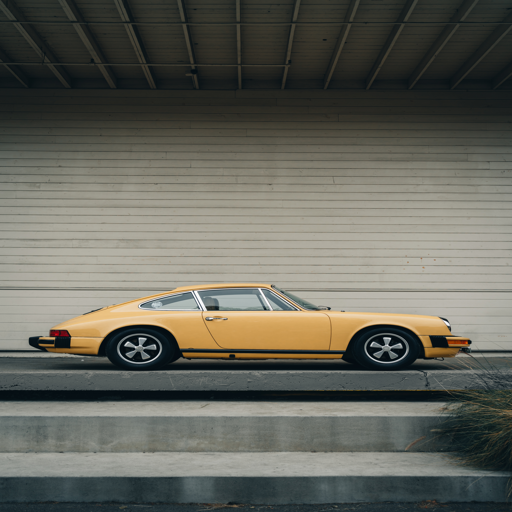

In [17]:
pil_image.resize((512, 512))

In [18]:
def pil_to_latents(pil_image):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    image = np.asarray(pil_image)
    image = jax.image.resize(image, (512, 512, 3), "bicubic")
    image = (image / 127.5 - 1.0).astype(np.float32)
    input_im = jnp.expand_dims(image, axis=0)
    input_im = jnp.transpose(input_im, (0, 3, 1, 2))
    # encode the image
    latents = vae.apply({"params": vae_params}, input_im, method=vae.encode)
    return 0.18215 * latents.latent_dist.sample(prng_seed)

In [19]:
def latents_to_pil(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    images = vae.apply({"params": vae_params}, latents, method=vae.decode).sample
    # convert JAX to numpy
    images = (images / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    images = np.asarray(images)
    # convert numpy array to PIL
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [20]:
%%time

encoded = pil_to_latents(pil_image)

CPU times: user 34.9 s, sys: 3 s, total: 37.9 s
Wall time: 27.2 s


In [21]:
encoded.shape

(1, 64, 64, 4)

In [22]:
encoded = jnp.transpose(encoded, (0, 3, 1, 2))
encoded.shape

(1, 4, 64, 64)

This 'sigma' is the amount of noise added to the latent representation. Let's visualize what this looks like by adding a bit of noise to our encoded image and then decoding this noised version:

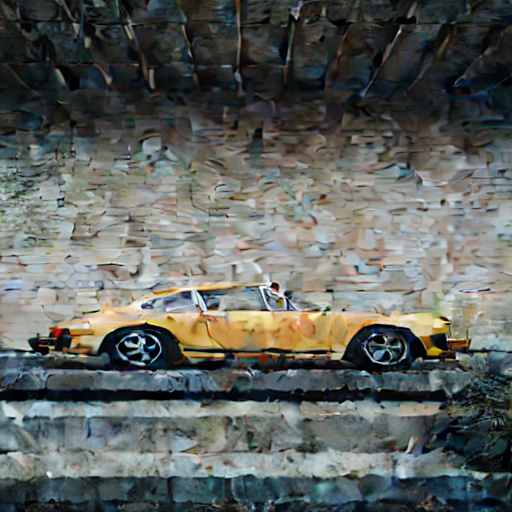

In [23]:
scheduler_state = scheduler.set_timesteps(scheduler_params, num_inference_steps=15, shape=encoded.shape)
noise = jax.random.normal(prng_seed, shape=encoded.shape, dtype=jnp.float32) # Random noise
sampling_step = 13 # Equivalent to step 13 out of 15 in the schedule above
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=scheduler_state.timesteps[sampling_step])
latents_to_pil(encoded_and_noised)[0] # Display

In [24]:
# init
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)

# call
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor


In [25]:
%%time 

# prepare_inputs
text_input = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
prompt_ids = text_input.input_ids
prompt_ids

CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 1.73 ms


array([[49406,   320,  1125,   539,   518, 16094,   539,   320,  1305,
          530,   518,  7301,   539, 31443,  4019, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407]])

In [26]:
%%time

# get prompt text embeddings
text_embeddings = text_encoder(prompt_ids, params=text_encoder_params)[0]

CPU times: user 2.9 s, sys: 635 ms, total: 3.54 s
Wall time: 6.29 s


In [27]:
batch_size = prompt_ids.shape[0]
max_length = prompt_ids.shape[-1]

In [28]:
uncond_input = tokenizer(
  [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
).input_ids

uncond_embeddings = text_encoder(uncond_input, params=text_encoder_params)[0]

In [29]:
context = jnp.concatenate([uncond_embeddings, text_embeddings])

In [30]:
latents_shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

latents_shape

(1, 4, 64, 64)

In [31]:
# set the timestamps based on the number of steps
scheduler_state = scheduler.set_timesteps(
    scheduler_params, num_inference_steps=num_inference_steps, shape=latents_shape
    )

In [32]:
start_step = 10

Prep latents (noising appropriately for start_step)

In [33]:
noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
# scale the initial noise by the standard deviation required by the scheduler
noise = noise * scheduler.init_noise_sigma

latents = scheduler.add_noise(encoded, noise, timesteps=scheduler_state.timesteps[start_step])

In [34]:
def diffusion_loop(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)
    
    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])
    
    latents_input = scheduler.scale_model_input(scheduler_state, latents_input, t)
    
    # predict the noise residual
    noise_pred = unet.apply(
        {"params": unet_params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=context,
        ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents, scheduler_state = scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
    
    return latents, scheduler_state

In [35]:
%%time

latents, _ = jax.lax.fori_loop(start_step, num_inference_steps, diffusion_loop, (latents, scheduler_state))

CPU times: user 52min 42s, sys: 18.7 s, total: 53min
Wall time: 28min 16s


In [36]:
%%time

images = latents_to_pil(latents)

CPU times: user 1min 4s, sys: 1.36 s, total: 1min 6s
Wall time: 36.1 s


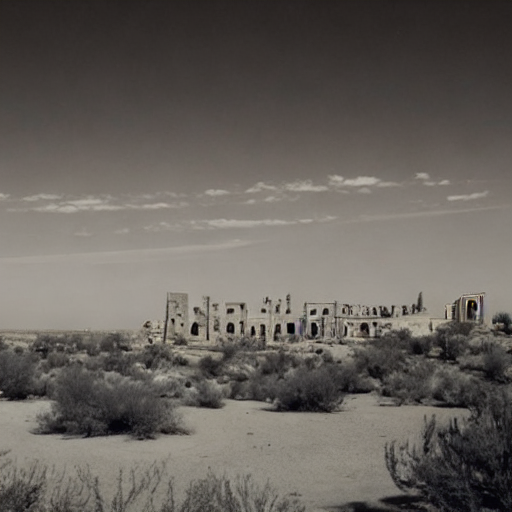

In [37]:
images[0]